# Hyperparameter Tuning {#sec-hyperparameter-tuning}

Hyperparameter tuning is an important, but often difficult and computationally intensive task.
Changing the architecture of a neural network or the learning rate of an optimizer can have a significant impact on the performance.

The goal of hyperparameter tuning is to optimize the hyperparameters in a way that improves the performance of the machine learning or deep learning model.
The simplest, but also most computationally expensive, approach uses manual search (or trial-and-error [@Meignan:2015vp]).
Commonly encountered is simple random search, i.e., random and repeated selection of hyperparameters for evaluation, and lattice search ("grid search").
In addition, methods that perform directed search  and other model-free algorithms, i.e., algorithms that do not explicitly rely on a model, e.g., evolution strategies [@Bart13j] or pattern search [@Torczon00] play an important role.
Also, "hyperband", i.e., a multi-armed bandit strategy that dynamically allocates resources to a set of random configurations and uses successive bisections to stop configurations with poor performance [@Li16a], is very common in hyperparameter tuning.
The most sophisticated and efficient approaches are the Bayesian optimization and surrogate model based optimization methods, which are based on the optimization of cost functions determined by simulations or experiments.

We consider below a surrogate model based optimization-based hyperparameter tuning approach based on the Python version of the SPOT ("Sequential Parameter Optimization Toolbox") [@BLP05], which is suitable for situations where only limited resources are available. This may be due to limited availability and cost of hardware, or due to the fact that confidential data may only be processed locally, e.g., due to legal requirements.
Furthermore, in our approach, the understanding of algorithms is seen as a key tool for enabling transparency and explainability. This can be enabled, for example, by quantifying the contribution of machine learning and deep learning components (nodes, layers, split decisions, activation functions, etc.).
Understanding the importance of hyperparameters and the interactions between multiple hyperparameters plays a major role in the interpretability and explainability of machine learning models.
SPOT provides statistical tools for understanding hyperparameters and their interactions. Last but not least, it should be noted that the SPOT software code is available in the open source `spotPython` package on github^[[https://github.com/sequential-parameter-optimization](https://github.com/sequential-parameter-optimization)], allowing replicability of the results.
This tutorial descries the Python variant of SPOT, which is called `spotPython`. The R implementation is described in @bart21i.
SPOT is an established open source software that has been maintained for more than 15 years [@BLP05] [@bart21i].

This tutorial is structured as follows. The concept of the hyperparameter tuning software `spotPython` is described in @sec-spot. 
@sec-quickstart ("Quickstart") describes the execution of the example from the tutorial "Hyperparameter Tuning with Ray Tune" [@pyto23a].
@sec-hyperparameter-tuning-for-pytorch describes the integration of `spotPython` into the ``PyTorch`` training workflow in detail and presents the results. Finally, @sec-summary presents a summary and an outlook.

::: {.callout-note}
The corresponding ` .ipynb` notebook [@bart23e] is updated regularly and reflects updates and changes in the `spotPython` package.
It can be downloaded from [https://github.com/sequential-parameter-optimization/spotPython/blob/main/notebooks/14_spot_ray_hpt_torch_cifar10.ipynb](https://github.com/sequential-parameter-optimization/spotPython/blob/main/notebooks/14_spot_ray_hpt_torch_cifar10.ipynb).
:::


# The Hyperparameter Tuning Software SPOT {#sec-spot}

Surrogate model based optimization methods are common approaches in simulation and optimization. SPOT was developed because there is a great need for sound statistical analysis of simulation and optimization algorithms. SPOT includes methods for tuning based on classical regression and analysis of variance techniques.
It presents tree-based models such as classification and regression trees and random forests as well as Bayesian optimization (Gaussian process models, also known as Kriging). Combinations of different meta-modeling approaches are possible. SPOT comes with a sophisticated surrogate model based optimization method, that can handle discrete and continuous inputs. Furthermore, any model implemented in `scikit-learn` can be used out-of-the-box as a surrogate in `spotPython`.

SPOT implements key techniques such as exploratory fitness landscape analysis and sensitivity analysis. It can be used to understand the performance of various algorithms, while simultaneously giving insights into their algorithmic behavior.
In addition, SPOT can be used as an optimizer and for automatic and interactive tuning. Details on SPOT and its use in practice are given by @bart21i.

A typical hyperparameter tuning process with `spotPython` consists of the following steps:

1. Loading the data (training and test datasets), see @sec-data-loading.
2. Specification of the preprocessing model, see @sec-specification-of-preprocessing-model. This model is called `prep_model` ("preparation" or pre-processing).
The information required for the hyperparameter tuning is stored in the dictionary `fun_control`. Thus, the information needed for the execution of the hyperparameter tuning is available in a readable form.
3. Selection of the machine learning or deep learning model to be tuned, see @sec-selection-of-the-algorithm. This is called the `core_model`. Once the `core_model` is defined, then the associated hyperparameters are stored in the `fun_control` dictionary. First, the hyperparameters of the `core_model` are initialized with the default values of the `core_model`.
As default values we use the default values contained in the `spotPython` package for the algorithms of the `torch` package.
4. Modification of the default values for the hyperparameters used in `core_model`, see @sec-modification-of-default-values. This step is optional.
   1. numeric parameters are modified by changing the bounds.
   2. categorical parameters are modified by changing the categories ("levels").
5. Selection of target function (loss function) for the optimizer, see @sec-selection-of-target-function.
6. Calling SPOT with the corresponding parameters, see @sec-call-the-hyperparameter-tuner. The results are stored in a dictionary and are available for further analysis.
7. Presentation, visualization and interpretation of the results, see @sec-results-tuning.


# Quickstart {#sec-quickstart}

In [1]:
#| echo: true
#| eval: false
import numpy as np
import pandas as pd
import itertools
from math import inf
import torch
import torchmetrics
from torch.nn import CrossEntropyLoss, NLLLoss
import torch.nn as nn

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from spotPython.spot import spot
from spotPython.utils.init import fun_control_init
from spotPython.data.torchdata import load_data_cifar10
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    get_var_type,
    get_var_name,
    get_bound_values,
    get_one_core_model_from_X,
    get_default_hyperparameters_as_array
    )
from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch
from spotPython.torch.netvbdp import Net_vbdp
# from spotPython.torch.netcifar10 import Net_CIFAR10
from spotPython.torch.traintest import (
    train_tuned,
    test_tuned,
    )
from spotPython.torch.dataframedataset import DataFrameDataset
from spotPython.torch.mapk import MAPK
from spotPython.data.vbdp import modify_vbdp_dataframe

# Feature Engineering

In [2]:
#| echo: true
#| eval: false
fun_control = fun_control_init(task="classification", tensorboard_path="runs/25_spot_torch_vbdp")
fun_control.update({"show_batch_interval": 100_000_000})
# load data
train_df = pd.read_csv('./data/VBDP/train.csv')
# remove the id column
train_df = train_df.drop(columns=['id'])
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
target_column = "prognosis"
# # Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
train_df[target_column] = enc.fit_transform(train_df[[target_column]])

* feature engineering: 6112 features

In [3]:
# BIG_INPUT = False
# if BIG_INPUT:
#     # convert all train.df columns to int   
#     train_0 = train_df.astype(int)
#     col_prognosis = train_0['prognosis']
#     train_x = train_0.drop(columns=['prognosis'])
#     train_x = combine_features(train_x)
#     train_x['prognosis'] = col_prognosis
#     train_df = train_x.copy()
#     train_df.head()

* feature engineering: 69 features

In [4]:
# if BIG_INPUT == True:
#     # convert all train.df columns to int   
#     train_df = train_df.astype(int)
#     col_prognosis = train_df['prognosis']
#     train_features = cluster_features(train_df.drop(columns=['prognosis']))    
#     train_df = affinity_propagation_features(train_features)
#     train_df['prognosis'] = col_prognosis
# train_df.head()

In [5]:
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
train_df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column, axis=1), train_df[target_column],
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=train_df[target_column])
trainset = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
testset = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))
trainset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
testset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
print(train_df.shape)
print(trainset.shape)
print(testset.shape)


(707, 65)
(530, 65)
(177, 65)


In [6]:
dtype_x = torch.float32
dtype_y = torch.long
train_df = DataFrameDataset(train_df, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
train = DataFrameDataset(trainset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
test = DataFrameDataset(testset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
n_samples = len(train)

In [7]:
# add the dataset to the fun_control
fun_control.update({"data": train_df, # full dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": target_column})


In [8]:

# add the nn model to the fun_control dictionary
fun_control = add_core_model_to_fun_control(core_model=Net_vbdp,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict)
# modify the hyperparameter levels
fun_control = modify_hyper_parameter_bounds(fun_control, "_L0", bounds=[n_features, n_features])
fun_control = modify_hyper_parameter_bounds(fun_control, "l1", bounds=[3, 4])
fun_control = modify_hyper_parameter_bounds(fun_control, "epochs", bounds=[2, 9])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[2, 5])
fun_control = modify_hyper_parameter_bounds(fun_control, "lr_mult", bounds=[1e-3, 1e-3])
fun_control = modify_hyper_parameter_bounds(fun_control, "sgd_momentum", bounds=[0.9, 0.9])
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",["Adam", "NAdam"])
# select metric and loss function
# metric_torch = torchmetrics.Accuracy(task="multiclass", num_classes=11)
metric_torch = MAPK(k=3)
loss_torch = CrossEntropyLoss()
# loss_torch = NLLLoss()
fun_control.update({
               "metric_torch": metric_torch,
               "loss_function": loss_torch,
               "device": "cpu",
               })
# extract the variable types, names, and bounds
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

# get the default hyperparameters as array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)

# get the objective function
fun = HyperTorch().fun_torch

# initialize spot
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 1,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 5,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
# run spot
spot_tuner.run(X_start=X_start)



config: {'_L0': 64, 'l1': 16, 'dropout_prob': 0.7103122166156, 'lr_mult': 0.001, 'batch_size': 4, 'epochs': 32, 'k_folds': 1, 'patience': 32, 'optimizer': 'Adam', 'sgd_momentum': 0.9}
Epoch: 1
Loss on hold-out set: 2.3990925213076033
Accuracy on hold-out set: 0.07547169811320754
MAPK value on hold-out data: 0.11084905660377359
Epoch: 2
Loss on hold-out set: 2.3990239062399232
Accuracy on hold-out set: 0.0660377358490566
MAPK value on hold-out data: 0.10613207547169812
Epoch: 3
Loss on hold-out set: 2.3991311541143454
Accuracy on hold-out set: 0.08018867924528301
MAPK value on hold-out data: 0.11320754716981132
Epoch: 4
Loss on hold-out set: 2.39900289841418
Accuracy on hold-out set: 0.05188679245283019
MAPK value on hold-out data: 0.09905660377358491
Epoch: 5
Loss on hold-out set: 2.399056870982332
Accuracy on hold-out set: 0.06132075471698113
MAPK value on hold-out data: 0.10377358490566038
Epoch: 6
Loss on hold-out set: 2.399207056693311
Accuracy on hold-out set: 0.07075471698113207

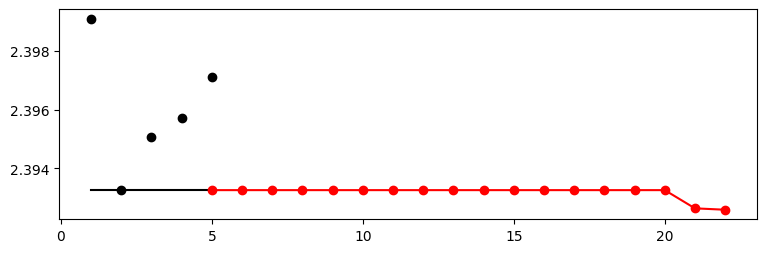

In [9]:
#| echo: true
#| eval: false
spot_tuner.plot_progress()

In [10]:
#| echo: true
#| eval: false
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name         | type   | default   |   lower |   upper |              tuned | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|--------------------|-----------------------|--------------|---------|
| _L0          | int    | 64        |    64.0 |    64.0 |               64.0 | None                  |         0.00 |         |
| l1           | int    | 8         |     3.0 |     4.0 |                3.0 | transform_power_2_int |         0.00 |         |
| dropout_prob | float  | 0.01      |     0.0 |     0.9 | 0.7216159470502945 | None                  |         0.03 |         |
| lr_mult      | float  | 1.0       |   0.001 |   0.001 |              0.001 | None                  |         0.00 |         |
| batch_size   | int    | 4         |     1.0 |     4.0 |                3.0 | transform_power_2_int |         0.00 |         |
| epochs       | int    | 4         |     2.0 |     9.0 |                8.0 | transform_power_2_int |  

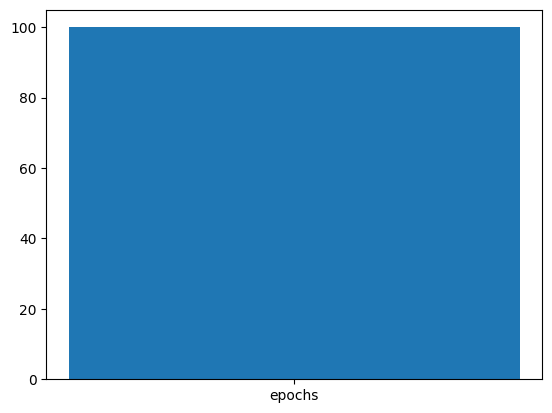

In [11]:
#| echo: true
#| eval: false
spot_tuner.plot_importance()

In [12]:
#| echo: true
#| eval: false
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_vbdp(
  (fc1): Linear(in_features=64, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=1, bias=True)
  (fc5): Linear(in_features=1, out_features=11, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout1): Dropout(p=0.7216159470502945, inplace=False)
  (dropout2): Dropout(p=0.36080797352514726, inplace=False)
)

In [13]:
from spotPython.torch.mapk import MAPK
metric_torch = MAPK(k=3)
fun_control.update({
               "metric_torch": metric_torch,               
               })

train_tuned(net=model_spot, train_dataset=train,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=True,
        device = "cpu",
        path=None,
        task=fun_control["task"],)

Epoch: 1
Loss on hold-out set: 2.3994201024373374
Accuracy on hold-out set: 0.08018867924528301
MAPK value on hold-out data: 0.08490566037735849
Epoch: 2
Loss on hold-out set: 2.3990381028917103
Accuracy on hold-out set: 0.08018867924528301
MAPK value on hold-out data: 0.08490566037735849
Epoch: 3
Loss on hold-out set: 2.3994960961518466
Accuracy on hold-out set: 0.08018867924528301
MAPK value on hold-out data: 0.08490566037735849
Epoch: 4
Loss on hold-out set: 2.399358661086471
Accuracy on hold-out set: 0.08018867924528301
MAPK value on hold-out data: 0.08490566037735849
Epoch: 5
Loss on hold-out set: 2.3996523044727467
Accuracy on hold-out set: 0.08018867924528301
MAPK value on hold-out data: 0.08490566037735849
Epoch: 6
Loss on hold-out set: 2.399755424923367
Accuracy on hold-out set: 0.08018867924528301
MAPK value on hold-out data: 0.08490566037735849
Epoch: 7
Loss on hold-out set: 2.3987830215030246
Accuracy on hold-out set: 0.08018867924528301
MAPK value on hold-out data: 0.08490

In [14]:
test_tuned(net=model_spot, test_dataset=test,
            shuffle=False,
            loss_function=fun_control["loss_function"],
            metric=fun_control["metric_torch"],
            device = "cpu",
            task=fun_control["task"],)

Loss on hold-out set: 2.4046211346336035
Accuracy on hold-out set: 0.096045197740113
MAPK value on hold-out data: 0.07062146892655367
Final evaluation: Validation loss: 2.4046211346336035
Final evaluation: Validation metric: 0.07062146892655367
----------------------------------------------


(2.4046211346336035, nan, 0.07062146892655367)

## Cross-validated Evaluations

* This is the evaluation that will be used in the comparison (evaluatecv has to be updated before, to get metric vlaues!):

In [15]:
from spotPython.torch.traintest import evaluate_cv
# modify k-kolds:
setattr(model_spot, "k_folds",  10)
evaluate_cv(net=model_spot, dataset=fun_control["data"], loss_function=fun_control["loss_function"], metric=fun_control["metric_torch"], task=fun_control["task"], writer=fun_control["writer"], writerId="model_spot_cv", device="cpu")

Fold: 1
Epoch: 1
Loss on hold-out set: 2.406664424472385
Accuracy on hold-out set: 0.04225352112676056
MAPK value on hold-out data: 0.11502347417840375
Epoch: 2
Loss on hold-out set: 2.405542665057712
Accuracy on hold-out set: 0.04225352112676056
MAPK value on hold-out data: 0.11502347417840375
Epoch: 3
Loss on hold-out set: 2.406181494394938
Accuracy on hold-out set: 0.04225352112676056
MAPK value on hold-out data: 0.11502347417840375
Epoch: 4
Loss on hold-out set: 2.405602057774862
Accuracy on hold-out set: 0.04225352112676056
MAPK value on hold-out data: 0.11502347417840375
Epoch: 5
Loss on hold-out set: 2.405257092581855
Accuracy on hold-out set: 0.04225352112676056
MAPK value on hold-out data: 0.11502347417840375
Epoch: 6
Loss on hold-out set: 2.4059330092536078
Accuracy on hold-out set: 0.04225352112676056
MAPK value on hold-out data: 0.11502347417840375
Epoch: 7
Loss on hold-out set: 2.405509180492825
Accuracy on hold-out set: 0.04225352112676056
MAPK value on hold-out data: 0.1

(2.398162661658393, nan, 0.15093896713615024)

dropout_prob:  0.03009907595886806
epochs:  100.0


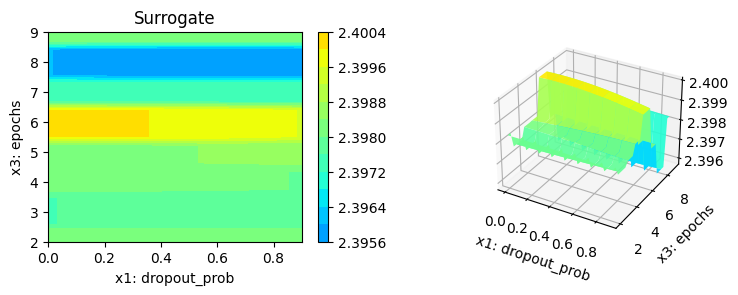

In [16]:
#| echo: true
#| eval: false
spot_tuner.plot_important_hyperparameter_contour()

In [17]:
# close tensorbaoard writer
if fun_control["writer"] is not None:
    fun_control["writer"].close()